In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
orders = pd.read_csv(
    "/content/drive/MyDrive/Thư mục mới/Orders.csv",
    nrows=300000
)


In [4]:
orders.shape
orders.head()

,ORDERID,BRANCH_ID,DATE_,USERID,NAMESURNAME,TOTALBASKET
0,7905270,320-DE1,2022-08-22 00:00:00,72946,Ali İlhan,"2637,5499999999997"
1,8131447,56-AN4,2022-06-05 00:00:00,58126,Aysun Dinç,"2262,06"
2,10176430,348-MU1,2023-01-02 00:00:00,41317,Taner Yavuz,"2195,54"
3,8445704,39-AY3,2021-01-28 00:00:00,39303,Esra Lara Keleş,"446,86"
4,8616360,777-YA1,2022-10-24 00:00:00,64870,Ela Çakır,"430,18"


In [16]:
customers = pd.read_csv(
    "/content/drive/MyDrive/Thư mục mới/Customers.csv",
     sep=';',
    engine="python",
    on_bad_lines='skip'
)

branches = pd.read_csv(
    "/content/drive/MyDrive/Thư mục mới/Branches.csv",
     sep=',',
    engine="python",
    on_bad_lines='skip'
)

customers.shape, branches.shape


((99998, 11), (957, 7))

In [14]:
customers.columns

Index(['USERID', 'USERNAME_', 'NAMESURNAME', 'STATUS_', 'USERGENDER',
       'USERBIRTHDATE', 'REGION', 'CITY', 'TOWN', 'DISTRICT', 'ADDRESSTEXT'],
      dtype='object')

In [17]:
branches.columns

Index(['BRANCH_ID', 'REGION', 'CITY', 'TOWN', 'BRANCH_TOWN', 'LAT', 'LON'], dtype='object')

In [18]:
orders.columns

Index(['ORDERID', 'BRANCH_ID', 'DATE_', 'USERID', 'NAMESURNAME',
       'TOTALBASKET'],
      dtype='object')

In [19]:
# Join Orders + Customers
df = orders.merge(
    customers,
    on="USERID",
    how="left"
)

# Join tiếp với Branches
df = df.merge(
    branches,
    on="BRANCH_ID",
    how="left"
)

df.shape

(2401822, 22)

In [20]:
df.columns

Index(['ORDERID', 'BRANCH_ID', 'DATE_', 'USERID', 'NAMESURNAME_x',
       'TOTALBASKET', 'USERNAME_', 'NAMESURNAME_y', 'STATUS_', 'USERGENDER',
       'USERBIRTHDATE', 'REGION_x', 'CITY_x', 'TOWN_x', 'DISTRICT',
       'ADDRESSTEXT', 'REGION_y', 'CITY_y', 'TOWN_y', 'BRANCH_TOWN', 'LAT',
       'LON'],
      dtype='object')

In [21]:
selected_cols = [
    'TOTALBASKET',
    'DATE_',
    'USERGENDER',
    'USERBIRTHDATE',
    'STATUS_',
    'REGION_x',
    'CITY_x',
    'REGION_y',
    'CITY_y',
    'LAT',
    'LON',
    'BRANCH_ID'
]

df_ml = df[selected_cols]

df_ml.head()


,TOTALBASKET,DATE_,USERGENDER,USERBIRTHDATE,STATUS_,REGION_x,CITY_x,REGION_y,CITY_y,LAT,LON,BRANCH_ID
0,"2637,5499999999997",2022-08-22 00:00:00,E,1978-03-01,1,Ege,Denizli,Ege,Denizli,3743333330,2935000000,320-DE1
1,"2637,5499999999997",2022-08-22 00:00:00,E,1978-03-01,1,Ege,Denizli,Ege,Denizli,3722219310,2890919140,320-DE1
2,"2637,5499999999997",2022-08-22 00:00:00,E,1978-03-01,1,Ege,Denizli,Ege,Denizli,3707083070,2934536110,320-DE1
3,"2637,5499999999997",2022-08-22 00:00:00,E,1978-03-01,1,Ege,Denizli,Ege,Denizli,3758066450,2926984890,320-DE1
4,"2262,06",2022-06-05 00:00:00,K,1973-12-31,1,İç Anadolu,Ankara,İç Anadolu,Ankara,4002175100,3234095000,56-AN4


In [22]:
# Đổi TOTALBASKET từ string sang float
df_ml['TOTALBASKET'] = (
    df_ml['TOTALBASKET']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

df_ml['TOTALBASKET'].describe()


,TOTALBASKET
count,2.401822e+06
mean,1.280474e+03
std,1.574301e+03
min,0.000000e+00
25%,4.032400e+02
50%,9.350200e+02
75%,1.728150e+03
max,2.221602e+05


In [23]:
# Đổi DATE_ sang datetime
df_ml['DATE_'] = pd.to_datetime(df_ml['DATE_'])

# Tạo feature thời gian
df_ml['ORDER_YEAR'] = df_ml['DATE_'].dt.year
df_ml['ORDER_MONTH'] = df_ml['DATE_'].dt.month
df_ml['ORDER_DAY'] = df_ml['DATE_'].dt.day
df_ml['ORDER_WEEKDAY'] = df_ml['DATE_'].dt.weekday  # 0 = Monday

df_ml[['DATE_', 'ORDER_YEAR', 'ORDER_MONTH', 'ORDER_DAY', 'ORDER_WEEKDAY']].head()


,DATE_,ORDER_YEAR,ORDER_MONTH,ORDER_DAY,ORDER_WEEKDAY
0,2022-08-22,2022,8,22,0
1,2022-08-22,2022,8,22,0
2,2022-08-22,2022,8,22,0
3,2022-08-22,2022,8,22,0
4,2022-06-05,2022,6,5,6


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ORDER_MONTH'].plot(kind='hist', bins=20, title='ORDER_MONTH')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ORDER_DAY'].plot(kind='hist', bins=20, title='ORDER_DAY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ORDER_WEEKDAY'].plot(kind='hist', bins=20, title='ORDER_WEEKDAY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='ORDER_MONTH', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='ORDER_MONTH', y='ORDER_DAY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='ORDER_DAY', y='ORDER_WEEKDAY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DATE_']
  ys = series['ORDER_MONTH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('DATE_', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE_')
_ = plt.ylabel('ORDER_MONTH')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DATE_']
  ys = series['ORDER_DAY']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('DATE_', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE_')
_ = plt.ylabel('ORDER_DAY')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['DATE_']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'DATE_'}, axis=1)
              .sort_values('DATE_', ascending=True))
  xs = counted['DATE_']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('DATE_', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE_')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['ORDER_MONTH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('ORDER_MONTH')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['ORDER_MONTH'].plot(kind='line', figsize=(8, 4), title='ORDER_MONTH')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['ORDER_DAY'].plot(kind='line', figsize=(8, 4), title='ORDER_DAY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['ORDER_WEEKDAY'].plot(kind='line', figsize=(8, 4), title='ORDER_WEEKDAY')
plt.gca().spines[['top', 'right']].set_visible(False)

In [24]:
# Đổi USERBIRTHDATE sang datetime
df_ml['USERBIRTHDATE'] = pd.to_datetime(df_ml['USERBIRTHDATE'], errors='coerce')

# Lấy năm hiện tại từ dữ liệu (không dùng năm hệ thống → đúng khoa học)
current_year = df_ml['ORDER_YEAR'].max()

# Tính tuổi
df_ml['AGE'] = current_year - df_ml['USERBIRTHDATE'].dt.year

# Kiểm tra nhanh
df_ml[['USERBIRTHDATE', 'AGE']].describe()


,USERBIRTHDATE,AGE
count,2401822,2.401822e+06
mean,1975-01-23 12:07:55.343135360,4.843589e+01
min,1950-01-01 00:00:00,2.400000e+01
25%,1962-07-10 00:00:00,3.600000e+01
50%,1975-01-30 00:00:00,4.800000e+01
75%,1987-08-06 00:00:00,6.100000e+01
max,1999-12-19 00:00:00,7.300000e+01
std,NaN,1.443505e+01


In [25]:
df_ml = df_ml.drop(columns=['USERBIRTHDATE', 'DATE_'])

df_ml.head()


,TOTALBASKET,USERGENDER,STATUS_,REGION_x,CITY_x,REGION_y,CITY_y,LAT,LON,BRANCH_ID,ORDER_YEAR,ORDER_MONTH,ORDER_DAY,ORDER_WEEKDAY,AGE
0,2637.55,E,1,Ege,Denizli,Ege,Denizli,3743333330,2935000000,320-DE1,2022,8,22,0,45
1,2637.55,E,1,Ege,Denizli,Ege,Denizli,3722219310,2890919140,320-DE1,2022,8,22,0,45
2,2637.55,E,1,Ege,Denizli,Ege,Denizli,3707083070,2934536110,320-DE1,2022,8,22,0,45
3,2637.55,E,1,Ege,Denizli,Ege,Denizli,3758066450,2926984890,320-DE1,2022,8,22,0,45
4,2262.06,K,1,İç Anadolu,Ankara,İç Anadolu,Ankara,4002175100,3234095000,56-AN4,2022,6,5,6,50


In [26]:
categorical_cols = [
    'USERGENDER',
    'REGION_x',
    'CITY_x',
    'REGION_y',
    'CITY_y',
    'BRANCH_ID'
]

df_ml[categorical_cols].nunique()

,0
USERGENDER,2
REGION_x,7
CITY_x,81
REGION_y,7
CITY_y,81
BRANCH_ID,161


In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))
    label_encoders[col] = le

df_ml[categorical_cols].head()


,USERGENDER,REGION_x,CITY_x,REGION_y,CITY_y,BRANCH_ID
0,0,2,21,2,21,45
1,0,2,21,2,21,45
2,0,2,21,2,21,45
3,0,2,21,2,21,45
4,1,6,5,6,5,104


In [28]:
# Tách X và y
X = df_ml.drop(columns=['TOTALBASKET'])
y = df_ml['TOTALBASKET']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((1921457, 14), (480365, 14))

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape


(1921457, 14)

In [31]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr.predict(X_test_scaled)

# Đánh giá
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, rmse_lr, r2_lr


(881.1577706502194, np.float64(1557.8470002019774), 0.027446747170574826)

In [33]:
# Lấy sample 300k dòng để train RF
sample_size = 300_000

X_train_rf = X_train.sample(sample_size, random_state=42)
y_train_rf = y_train.loc[X_train_rf.index]

# Train RF
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, y_train_rf)

# Predict vẫn dùng full test set
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf


(845.3955991212226, np.float64(1486.116884143348), 0.11494609477284135)

In [34]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]
})

results


,Model,MAE,RMSE,R2
0,Linear Regression,881.157771,1557.847000,0.027447
1,Random Forest,845.395599,1486.116884,0.114946


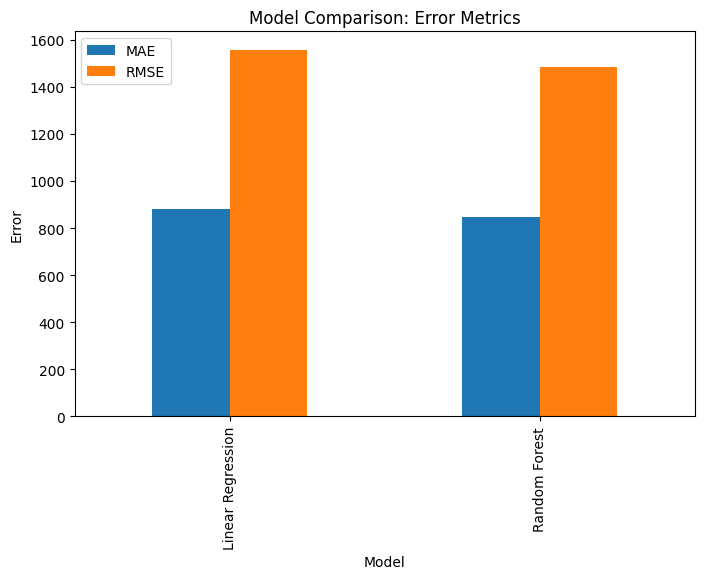

In [35]:
results.set_index("Model")[["MAE", "RMSE"]].plot(
    kind="bar",
    figsize=(8,5)
)
plt.title("Model Comparison: Error Metrics")
plt.ylabel("Error")
plt.show()
